In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
import time

In [62]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level= logging.INFO)

In [10]:
df= pd.read_csv("data.csv", index_col=0)
df.columns=df.columns.str.replace(" ", "_")
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [11]:
# Relation between Division name, Department name and Class name? 
df[['Division_Name','Department_Name','Class_Name']].groupby(['Division_Name','Department_Name','Class_Name']).agg('count')

Empty DataFrame
Columns: []
Index: [(General, Bottoms, Casual bottoms), (General, Bottoms, Jeans), (General, Bottoms, Pants), (General, Bottoms, Shorts), (General, Bottoms, Skirts), (General, Dresses, Dresses), (General, Jackets, Jackets), (General, Jackets, Outerwear), (General, Tops, Blouses), (General, Tops, Fine gauge), (General, Tops, Knits), (General, Tops, Sweaters), (General, Trend, Trend), (General Petite, Bottoms, Jeans), (General Petite, Bottoms, Pants), (General Petite, Bottoms, Skirts), (General Petite, Dresses, Dresses), (General Petite, Intimate, Lounge), (General Petite, Jackets, Jackets), (General Petite, Jackets, Outerwear), (General Petite, Tops, Blouses), (General Petite, Tops, Fine gauge), (General Petite, Tops, Knits), (General Petite, Tops, Sweaters), (General Petite, Trend, Trend), (Initmates, Intimate, Chemises), (Initmates, Intimate, Intimates), (Initmates, Intimate, Layering), (Initmates, Intimate, Legwear), (Initmates, Intimate, Lounge), (Initmates, Intimate, Sleep), (Initmates, Intimate, Swim)]

In [15]:
# Since the reviews is our main content, dropping rows where 'Review Text' is null
df.dropna(subset=['Review_Text'], inplace=True)
df.shape

(22641, 10)

In [16]:
# Review word count
df['rev_word_count']= df['Review_Text'].apply(lambda x: len(x.strip().split()))

# Unique word count
df['unique_word_count']= df['Review_Text'].apply(lambda x: len(set(str(x).split())))

In [18]:
# Bucketing Clothing ID's with 1 or 2 count

clothing_id_to_combine=[]
for val, cnt in df.Clothing_ID.value_counts().items():
    # If that Clothing_ID is present less than 1%(~200) of the total data, club it into '000' (default) id
    if(cnt<200):         
        clothing_id_to_combine.append(val)  
print("# of clothing ID's clubbed: ",len(clothing_id_to_combine))

df['new_clothingID']=[x if x not in clothing_id_to_combine else '000' for x in df['Clothing_ID'] ]

df['new_clothingID']

# of clothing ID's clubbed:  1151


0         000
1        1080
2        1077
3         000
4         000
         ... 
23481     000
23482     862
23483     000
23484     000
23485     000
Name: new_clothingID, Length: 22641, dtype: object

# Sentiment Analysis

Calibrating Title and Review sentiment scores using VADER Sentiment!
VADER (Valence Aware Dictionary and sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

In [25]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer= SentimentIntensityAnalyzer()

# Try it out!
vs= analyzer.polarity_scores("Love this dress! it's sooo pretty.")
print(vs)

{'neg': 0.0, 'neu': 0.342, 'pos': 0.658, 'compound': 0.8268}


In [26]:
df['review_sentiment']= [analyzer.polarity_scores(line)['compound'] for line in df['Review_Text']]

In [32]:
df['Review_Text'].where(df['review_sentiment']<0.3).dropna()

7        I ordered this in carbon for store pick up, an...
14       This is a nice choice for holiday gatherings. ...
32       These pants are even better in person. the onl...
57       This tank fit well and i loved the ruffle in t...
61       3 tags sewn in, 2 small (about 1'' long) and 1...
                               ...                        
23436    I'm 5'6" and it hits me at mid-thigh. the top ...
23449    I tried these on because the color is really p...
23462    The pattern of this skirt is adorable and look...
23477    I'm so impressed with the beautiful color comb...
23478    I was surprised at the positive reviews for th...
Name: Review_Text, Length: 2302, dtype: object

In [34]:
df.Title.fillna('no title', inplace=True)
df['title_sentiment']= df['Title'].apply(lambda x: analyzer.polarity_scores(x)['compound'] if str(x)!= 'no title' else 0.0)
for index, row in df[100:120].iterrows():
    print(row['Title']," >>>>>", row['title_sentiment'])

Not a fan  >>>>> -0.2411
no title  >>>>> 0.0
Excited ... but ...  >>>>> 0.1779
Beautiful shirt but runs small!  >>>>> 0.4102
Beautiful  >>>>> 0.5994
Perfect fall shirt!  >>>>> 0.6114
no title  >>>>> 0.0
Poor quality  >>>>> -0.4767
An almost for me...  >>>>> 0.0
Beautiful, stunning, cozy top!  >>>>> 0.8221
Cute and comfy  >>>>> 0.4588
Disappointing quality  >>>>> -0.4939
Cute tee  >>>>> 0.4588
Very vintage feel  >>>>> 0.0
no title  >>>>> 0.0
Awkward fitting  >>>>> -0.1531
Cozy casual - perfect for fall  >>>>> 0.6705
The perfect striped t  >>>>> 0.5719
no title  >>>>> 0.0
no title  >>>>> 0.0


In [35]:
df['total_sentiment_score']= df['title_sentiment']+ df['review_sentiment']

In [36]:
# Golden rule: Save up the original dataframe before encoding!
df_orig= df.copy()
df_orig.shape 


(22641, 16)

Feature Encoding and prepping up our data for clustering!

In [37]:
# Dropping text columns- we have already used them to calcuate the total sentiment score

df.drop(columns=['Review_Text','Title','Clothing_ID','review_sentiment','title_sentiment'], inplace=True)

In [38]:
# Deciding on categorical columns- object datatype -very slow processing

cat_cols= ['Division_Name','Department_Name','Class_Name','new_clothingID']
for col in cat_cols:
    print(col," has categories:", df[col].nunique())
    df[col]= df[col].astype('category')

Division_Name  has categories: 3
Department_Name  has categories: 6
Class_Name  has categories: 20
new_clothingID  has categories: 29


In [42]:
# Binary encoding our categorical columns

import category_encoders as ce

be= ce.BinaryEncoder(cols= cat_cols,drop_invariant=True).fit(df) 

df= be.transform(df)

In [43]:
df.head()

,Age,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name_0,Division_Name_1,Division_Name_2,Department_Name_0,Department_Name_1,Department_Name_2,...,Class_Name_3,Class_Name_4,rev_word_count,unique_word_count,new_clothingID_0,new_clothingID_1,new_clothingID_2,new_clothingID_3,new_clothingID_4,total_sentiment_score
0,33,4,1,0,0,0,1,0,0,1,...,0,1,8,7,0,0,0,0,1,0.8932
1,34,5,1,4,0,1,0,0,1,0,...,1,0,62,47,0,0,0,1,0,0.9729
2,60,3,0,0,0,1,0,0,1,0,...,1,0,98,72,0,0,0,1,1,0.9208
3,50,5,1,0,0,1,1,0,1,1,...,1,1,22,20,0,0,0,0,1,1.0820
4,47,5,1,6,0,1,0,1,0,0,...,0,0,36,28,0,0,0,0,1,1.2473


In [44]:
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.cluster import KMeans
import pylab as pl
%matplotlib inline
import matplotlib.pyplot as plt

In [50]:
pca_tsne= Pipeline([("pca", PCA(n_components= 0.90, random_state=33)),
                    ("tsne", TSNE(n_components=2,
                                  perplexity= 170,
                                  random_state=33, 
                                  learning_rate= 350, 
                                  max_iter= 5000,
                                  n_jobs=-1,
                                  n_iter_without_progress=150,
                                  verbose=1))])
t0= time.time()
df_pca_tsne_reduced= pca_tsne.fit_transform(df)
t1= time.time()

print("pca+tsne took:{:.1f}s ".format(t1-t0))

[t-SNE] Computing 511 nearest neighbors...
[t-SNE] Indexed 22641 samples in 0.009s...
[t-SNE] Computed neighbors for 22641 samples in 1.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22641
[t-SNE] Computed conditional probabilities for sample 2000 / 22641
[t-SNE] Computed conditional probabilities for sample 3000 / 22641
[t-SNE] Computed conditional probabilities for sample 4000 / 22641
[t-SNE] Computed conditional probabilities for sample 5000 / 22641
[t-SNE] Computed conditional probabilities for sample 6000 / 22641
[t-SNE] Computed conditional probabilities for sample 7000 / 22641
[t-SNE] Computed conditional probabilities for sample 8000 / 22641
[t-SNE] Computed conditional probabilities for sample 9000 / 22641
[t-SNE] Computed conditional probabilities for sample 10000 / 22641
[t-SNE] Computed conditional probabilities for sample 11000 / 22641
[t-SNE] Computed conditional probabilities for sample 12000 / 22641
[t-SNE] Computed conditional probabilities for sa

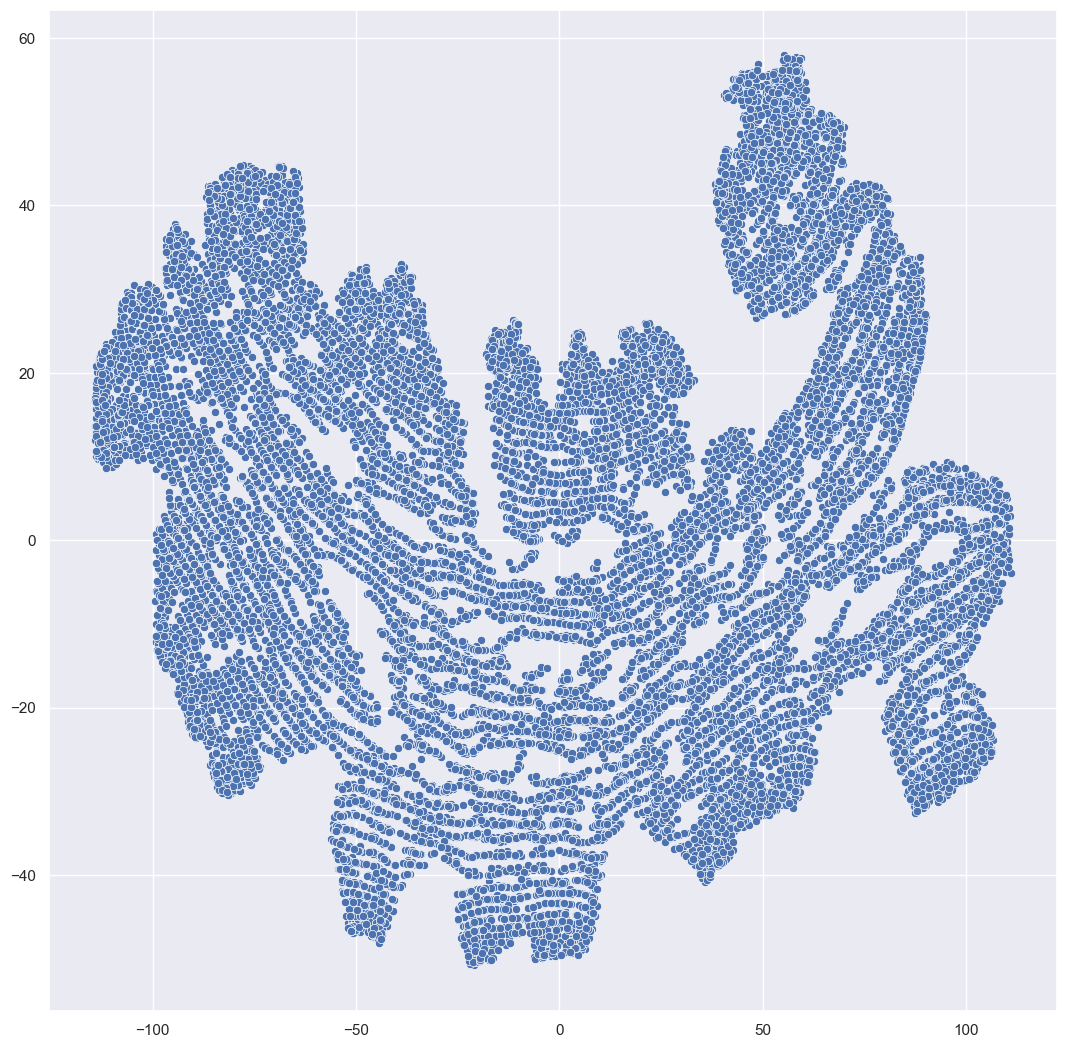

In [52]:
sns.set_theme(rc= {'figure.figsize': (13,13)})
sns.scatterplot(x=df_pca_tsne_reduced[:,0],y= df_pca_tsne_reduced[:,1])
plt.show()

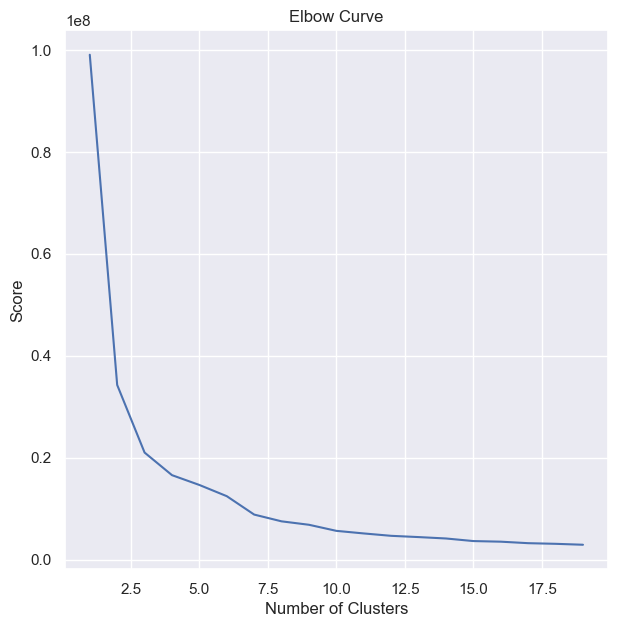

Plotting the Elbow curve took:0.5s 


In [53]:
review_data_std = stats.zscore(df_pca_tsne_reduced)
review_data_std = np.array(review_data_std)

sns.set_theme(rc= {'figure.figsize': (7,7)})
number_of_clusters = range(1,20)

t0= time.time()
kmeans = [KMeans(n_clusters=i,max_iter=1000,random_state=33) for i in number_of_clusters]
score = [-1*kmeans[i].fit(df_pca_tsne_reduced).score(df_pca_tsne_reduced) for i in range(len(kmeans))]
t1= time.time()

pl.plot((number_of_clusters),score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

In [54]:
k_means_test = KMeans(n_clusters=3, max_iter=1500, random_state=33,verbose=1)

#fitting on your model
-1*k_means_test.fit(df_pca_tsne_reduced).score(df_pca_tsne_reduced)
y_pred= k_means_test.labels_

# Assigning cluster labels to each data point
df_orig['klabels'] = k_means_test.labels_

Initialization complete
Iteration 0, inertia 28763110.0.
Iteration 1, inertia 21174394.0.
Iteration 2, inertia 21026176.0.
Iteration 3, inertia 21012308.0.
Iteration 4, inertia 21009018.0.
Converged at iteration 4: center shift 0.08152644336223602 within tolerance 0.2187786102294922.


In [58]:
# Analyzing 
size_of_each_cluster= df_orig.groupby('klabels').size().reset_index()
size_of_each_cluster.columns = ['klabels','number_of_points']
size_of_each_cluster['percentage'] = (size_of_each_cluster['number_of_points']/np.sum(size_of_each_cluster['number_of_points']))*100

print(size_of_each_cluster)

   klabels  number_of_points  percentage
0        0              7476   33.019743
1        1              7759   34.269688
2        2              7406   32.710569


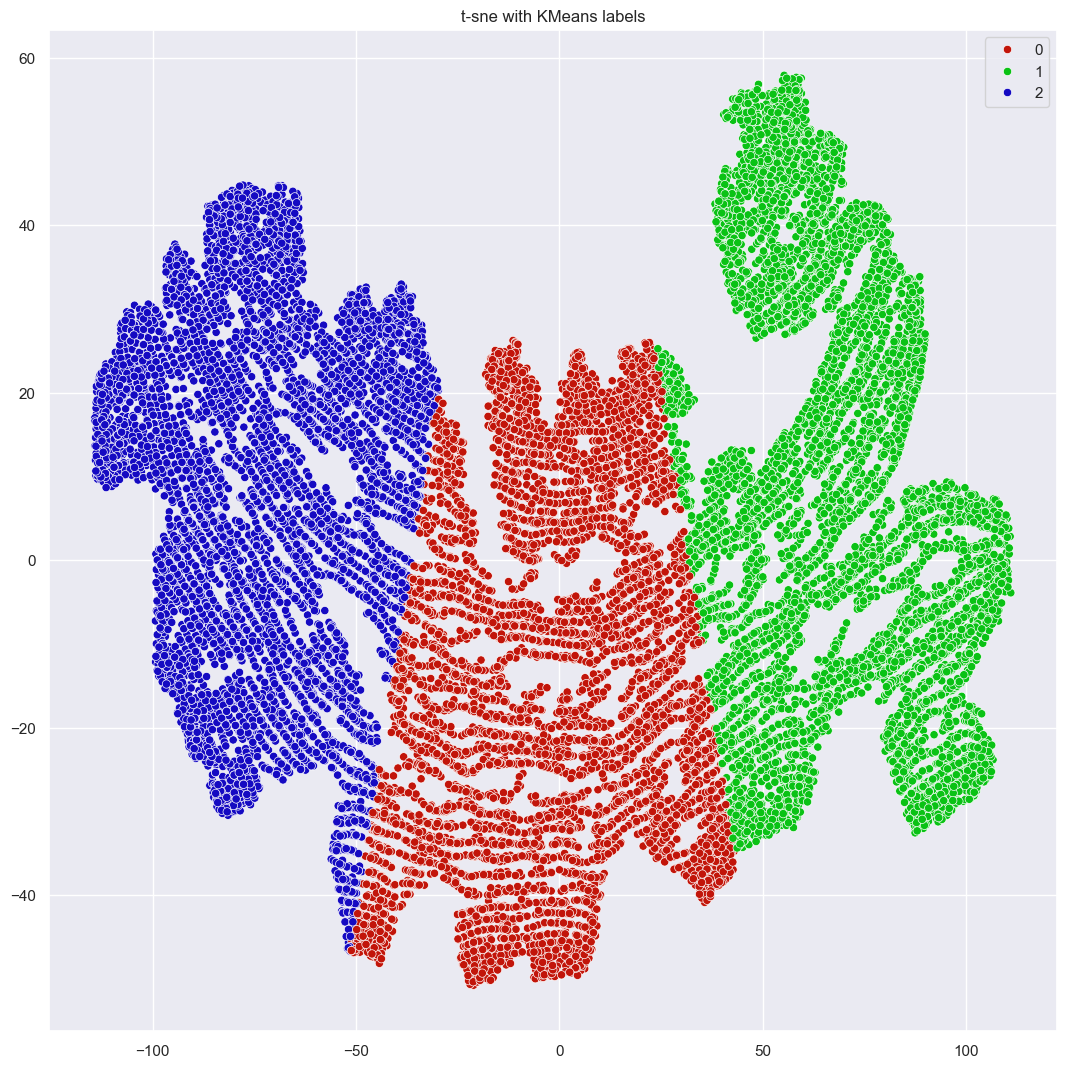

In [59]:
palette = sns.hls_palette(3, l=.4, s=.9)

sns.set_theme(rc= {'figure.figsize': (13,13)})
sns.scatterplot(x=df_pca_tsne_reduced[:,0],y= df_pca_tsne_reduced[:,1], hue= y_pred, legend='full', palette=palette)
plt.title("t-sne with KMeans labels")
plt.show()

Topic Modeling- Latent Dirichlet Allocation(LDA)

In [84]:
#STEP 1: Preprocessing text - Tokenizing sentences, stopwords removal and lemmatization
import spacy

# Load English model once
nlp = spacy.load("en_core_web_sm")

def preprocess_spacy(text):
    """ 1. Removes Punctuations
        2. Removes words smaller than 3 letters
        3. Converts into lowercase
        4. Lemmatizes words
        5. Removes Stopwords
    """
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        # filter out punctuation, stopwords, and short words
        if (not token.is_punct and
            not token.is_stop and
            len(token.text) > 3):
            tokens.append(token.lemma_.lower())
    
    return tokens

# Example usage
df_clean = df_orig['Review_Text'].apply(preprocess_spacy)
df_clean.head()


0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happen, find, stor...
2    [high, hope, dress, want, work, initially, ord...
3    [love, love, love, jumpsuit, flirty, fabulous,...
4    [shirt, flattering, adjustable, perfect, lengt...
Name: Review_Text, dtype: object

STEP 2: DATA CLEANING- PROCURE ONLY NOUNS AND ADJECTIVES TO OBTAIN MEANINGFUL TOPICS!

In [86]:
# Adding business stopwords to exclude

common_terms= ["wear","look","ordered","color","purchase","order"]

stoplist= stoplist+ common_terms

In [88]:
def get_nouns_adjs_spacy(token_list):
    # Join tokens to a single string
    text = " ".join(token_list)
    doc = nlp(text)
    nouns_adjs = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]
    return nouns_adjs

df_nouns_adj = df_clean.apply(get_nouns_adjs_spacy)

In [106]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert token lists back to strings
docs_as_strings = [' '.join(doc) for doc in df_nouns_adj]

# Create bigrams with CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=5)
X = vectorizer.fit_transform(docs_as_strings)

# View most frequent bigrams
bigrams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1
bigram_freq = list(zip(bigrams, counts))
bigram_freq.sort(key=lambda x: x[1], reverse=True)

# Print top 10 bigrams
for bigram, freq in bigram_freq[:10]:
    print(f"{bigram} >>>> {freq}")

true size >>>> 1346
size small >>>> 800
love dress >>>> 728
order size >>>> 559
love color >>>> 520
usual size >>>> 496
size size >>>> 460
fabric soft >>>> 442
order small >>>> 431
small size >>>> 421


In [107]:
valid_bigrams = set(bigram for bigram, count in bigram_freq if count > 200)

def insert_bigrams(doc):
    tokens = doc
    new_tokens = []
    i = 0
    while i < len(tokens) - 1:
        bigram = f"{tokens[i]} {tokens[i+1]}"
        if bigram in valid_bigrams:
            new_tokens.append(bigram.replace(" ", "_"))  # convert to single token
            i += 2
        else:
            new_tokens.append(tokens[i])
            i += 1
    if i == len(tokens) - 1:
        new_tokens.append(tokens[-1])
    return new_tokens

df_bigrams = df_nouns_adj.apply(insert_bigrams)

In [121]:
df_bigrams.head()

0                [wonderful, silky, sexy, comfortable]
1    [love_dress, sooo, store, glad, order, petite,...
2    [hope, dress, work, order_small, usual_size, s...
3            [love, fabulous, time, great, compliment]
4    [shirt, adjustable, perfect, length, wear, sle...
Name: Review_Text, dtype: object

In [109]:
docs_bigrams = [' '.join(doc) for doc in df_bigrams]  # Each document as a string with bigrams joined by underscore


In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(docs_bigrams)

In [145]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
lda_model.fit(X_tfidf)

,n_components,4
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [146]:
lda_doc_topic_distr = lda_model.transform(X_tfidf)

In [147]:
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 25

for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic #{topic_idx}: {' '.join(top_words)}")

Topic #0: shirt love fabric color dress material soft price great cute nice little design sweater size worth wear comfortable flattering love_shirt picture beautiful quality order fit
Topic #1: dress short length waist pant fabric love order petite long wash size color little skirt high great regular cute return small nice model shirt work
Topic #2: great love color dress comfortable perfect sweater wear soft jean purchase black fall cute beautiful summer jacket flattering nice piece pant compliment fit pair shirt
Topic #3: dress small size large love order little fabric chest waist shoulder tight medium great bust work cute short fit beautiful flattering retailer return material review


In [148]:
# Create a DataFrame from the doc-topic matrix if you like
df_doc_topics = pd.DataFrame(lda_doc_topic_distr, columns=[f"Topic_{i}" for i in range(lda_model.n_components)])

# Assign the topic with highest probability to each document
df_orig['major_lda_topic'] = df_doc_topics.values.argmax(axis=1)

In [149]:
topic_labels = {
    0: "Shirts & Fabric Quality",
    1: "Fit & Sizing for Bottomwear",
    2: "Comfortable Seasonal Wear",
    3: "Dress Fit & Size Concerns"
}

In [150]:
df_orig['topic_name'] = df_orig['major_lda_topic'].map(topic_labels)

In [151]:
df_orig.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,rev_word_count,unique_word_count,new_clothingID,review_sentiment,title_sentiment,total_sentiment_score,klabels,major_lda_topic,topic_name
0,767,33,no title,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8,7,000,0.8932,0.0000,0.8932,2,0,Shirts & Fabric Quality
1,1080,34,no title,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62,47,1080,0.9729,0.0000,0.9729,0,1,Fit & Sizing for Bottomwear
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,72,1077,0.9208,0.0000,0.9208,1,1,Fit & Sizing for Bottomwear
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,20,000,0.5727,0.5093,1.0820,2,2,Comfortable Seasonal Wear
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,28,000,0.9291,0.3182,1.2473,2,0,Shirts & Fabric Quality


<Axes: xlabel='major_lda_topic'>

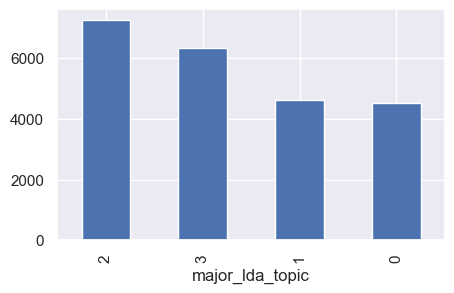

In [152]:
sns.set(rc= {'figure.figsize': (5,3)})
sns.set_style('darkgrid')

df_orig.major_lda_topic.value_counts().plot(kind='bar')

In [154]:
#Analyze K-means Clustering against Topic Labeling

In [155]:
df_orig.groupby(['klabels'])['major_lda_topic'].value_counts(ascending=False, normalize=True)

klabels  major_lda_topic
0        2                  0.315142
         3                  0.285848
         1                  0.202782
         0                  0.196228
1        3                  0.334321
         1                  0.256090
         2                  0.221163
         0                  0.188426
2        2                  0.425331
         3                  0.213341
         0                  0.213070
         1                  0.148258
Name: proportion, dtype: float64

In [156]:
num_cols= ['Age','Positive_Feedback_Count','rev_word_count', 'unique_word_count','total_sentiment_score']

cat_cols= ['major_lda_topic','Division_Name','Department_Name','Class_Name']

cluster1= df_orig.loc[(df_orig.klabels==0)]
cluster2= df_orig.loc[(df_orig.klabels==1)]
cluster3= df_orig.loc[(df_orig.klabels==2)]

<Axes: xlabel='Rating'>

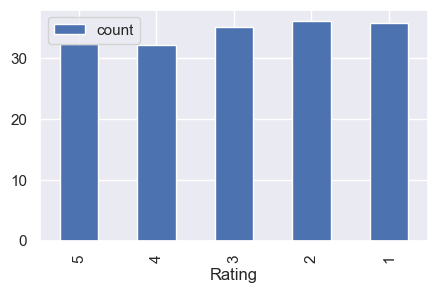

In [157]:
pd.DataFrame((cluster1.Rating.value_counts()*100)/df_orig.Rating.value_counts()).plot(kind='bar')

Visualizing numerical features:


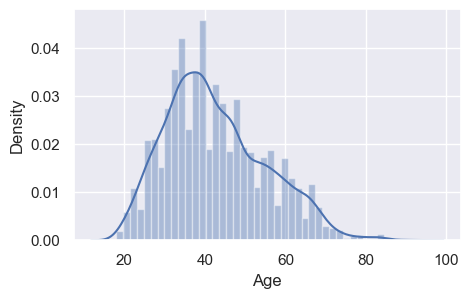

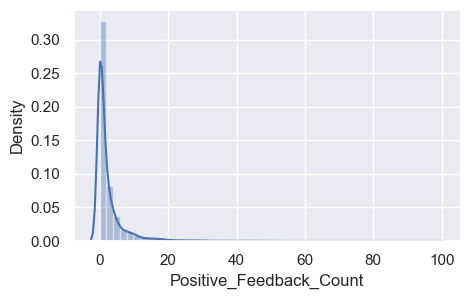

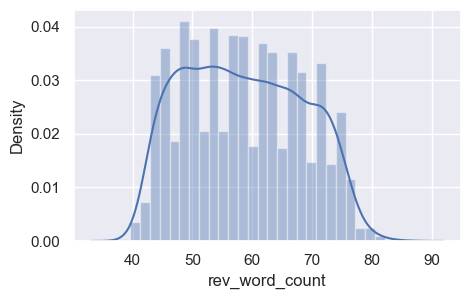

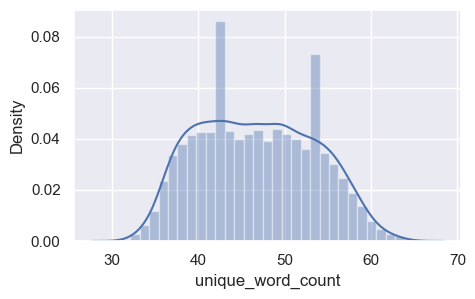

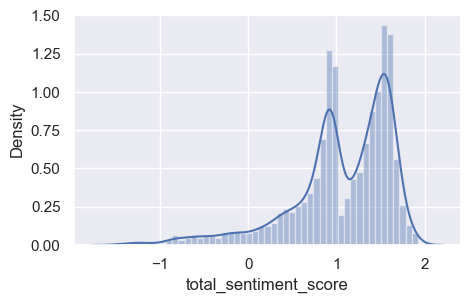

In [158]:
print('Visualizing numerical features:')
for i, col in enumerate(num_cols):
    plt.figure(i)
    sns.distplot(cluster1[col])


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Visualizing categorical features:


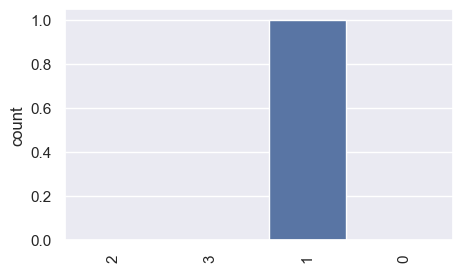

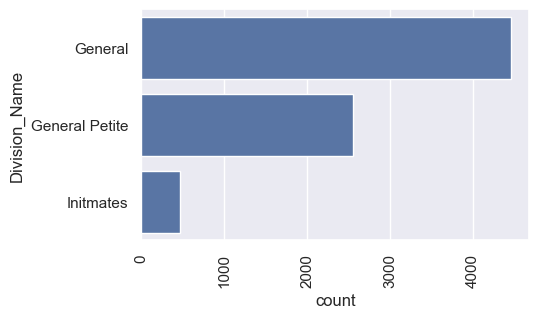

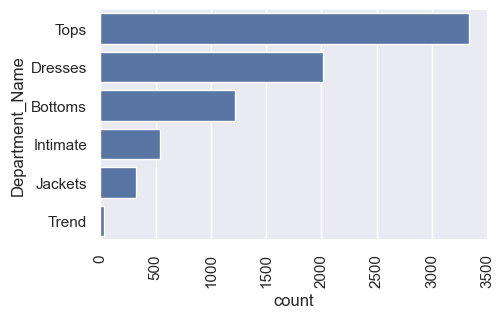

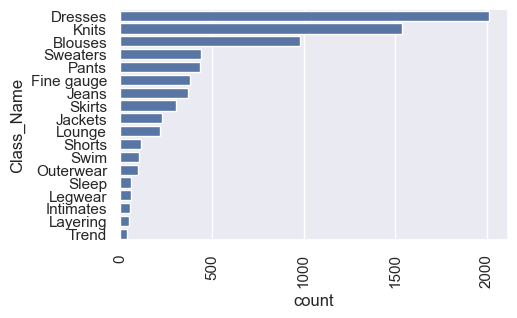

In [159]:
print('Visualizing categorical features:')
for i, col in enumerate(cat_cols):
    plt.figure(i)
    chart= sns.countplot(cluster1[col], order= cluster1[col].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

Visualizing numerical features:


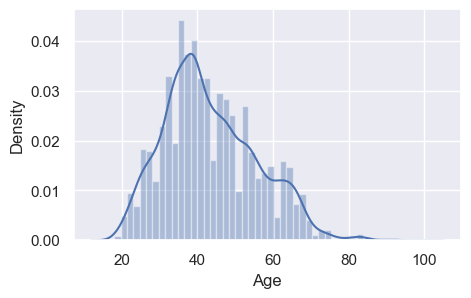

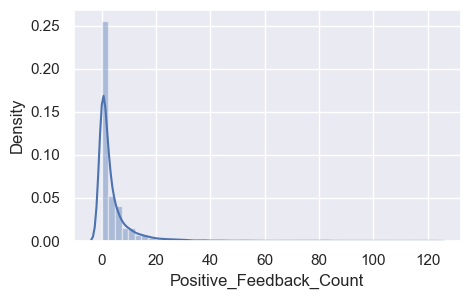

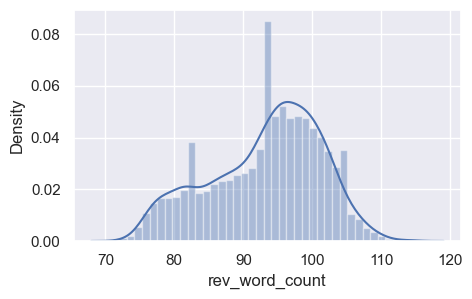

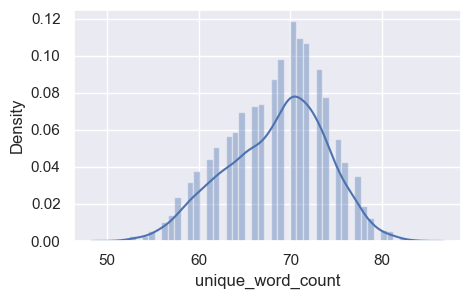

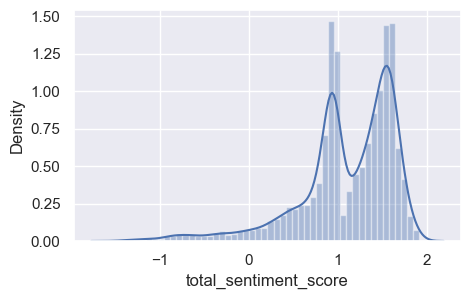

In [160]:
# **Cluster 2 Analysis**
print('Visualizing numerical features:')
for i, col in enumerate(num_cols):
    plt.figure(i)
    sns.distplot(cluster2[col])

<Axes: xlabel='Rating'>

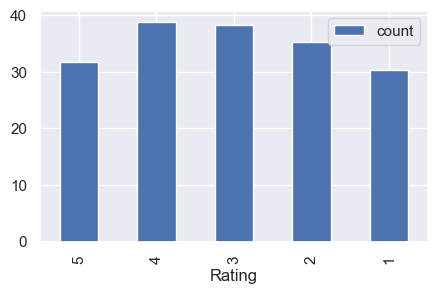

In [161]:
pd.DataFrame((cluster2.Rating.value_counts()*100)/df_orig.Rating.value_counts()).plot(kind='bar')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Visualizing categorical features:


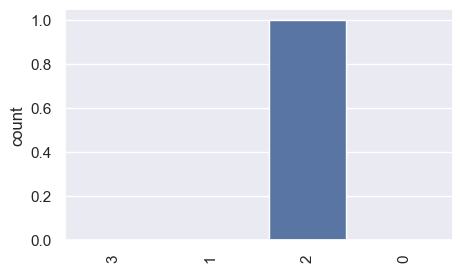

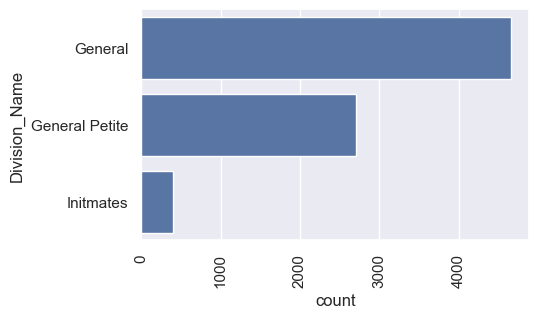

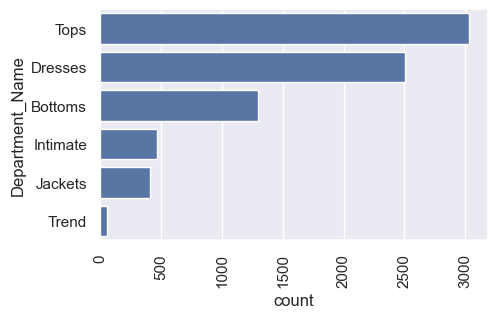

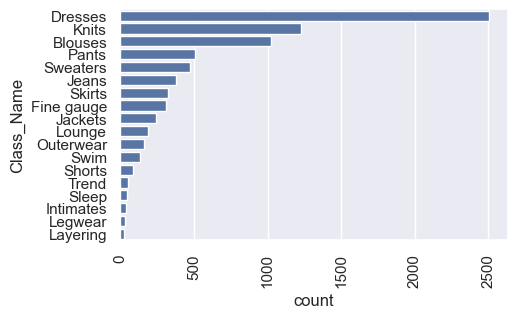

In [162]:
print('Visualizing categorical features:')
for i, col in enumerate(cat_cols):
    plt.figure(i)
    chart= sns.countplot(cluster2[col], order= cluster2[col].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<Axes: xlabel='Rating'>

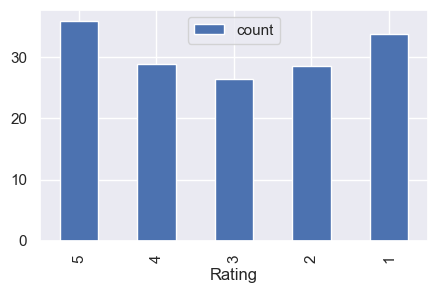

In [163]:
pd.DataFrame((cluster3.Rating.value_counts()*100)/df_orig.Rating.value_counts()).plot(kind='bar')

Visualizing numerical features:


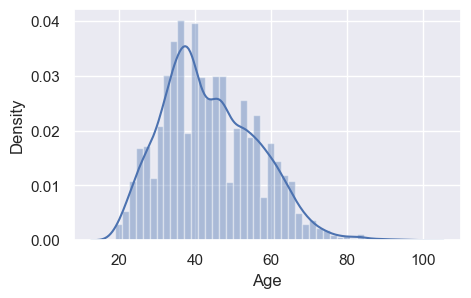

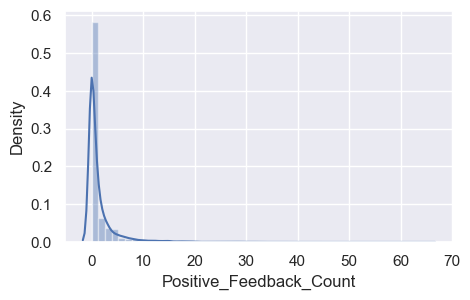

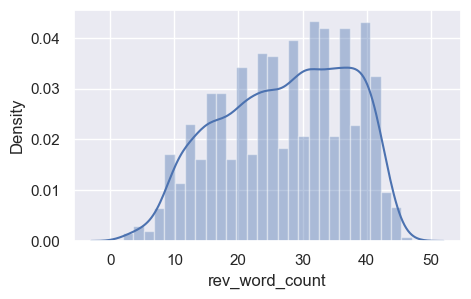

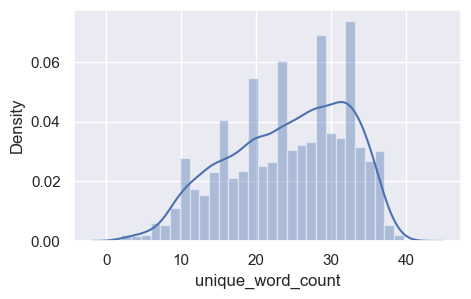

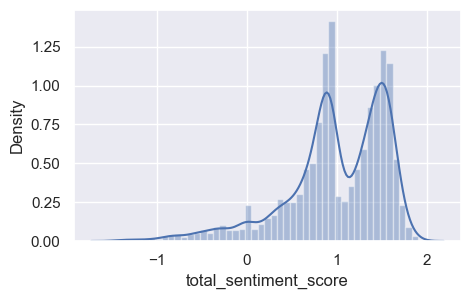

In [164]:
print('Visualizing numerical features:')
for i, col in enumerate(num_cols):
    plt.figure(i)
    sns.distplot(cluster3[col])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Visualizing categorical features:


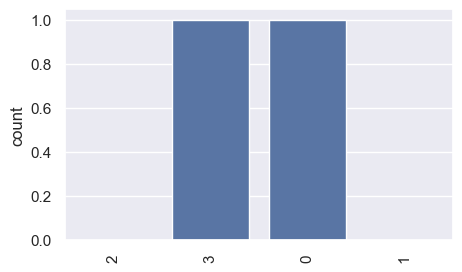

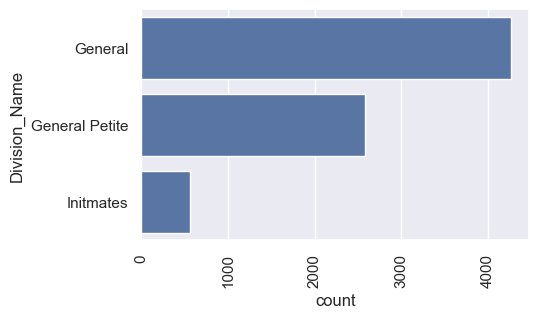

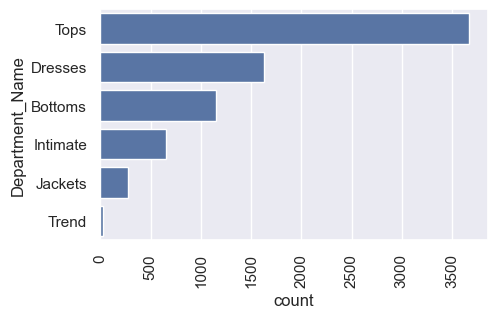

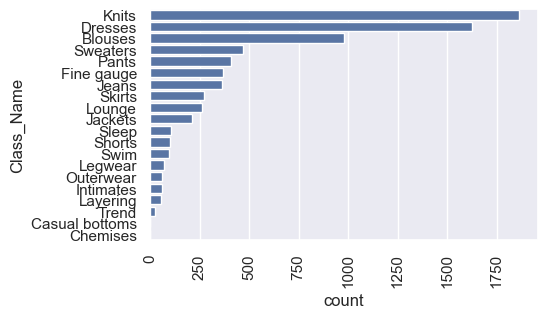

In [165]:
print('Visualizing categorical features:')
for i, col in enumerate(cat_cols):
    plt.figure(i)
    chart= sns.countplot(cluster3[col], order= cluster3[col].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)